In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def readGeosoftXYZ(fname):
    #TODO make this as pandas
    f = open(fname, 'r')
    data = f.readlines()
    temp = data[0].split()
    comments = temp[0]
    datalist = []
    icount = 0
    LineIdentifer = "%Line"
    header = data[5].split()
    for iline, line in enumerate(data[7:]):
        linelist = line.split()    
        if not (linelist==[] or '%/' in linelist):        
            datalist.append(linelist)
            icount+=1
    DAT = []
    Line=[]
    for idat, dat in enumerate (datalist):
        if LineIdentifer in dat:
            line = dat[1]
        elif isfloat(dat[0]):
            Line.append(int(line))
            DAT.append(np.array(map(float, dat))) 
    ndata = len(DAT)
    DAT = np.vstack(DAT)
    Line = np.array(Line)
    return {"DAT":DAT, "Line":Line, "header":header, "ndata":ndata}

In [5]:
fname = "/Users/sgkang/Dropbox/Shared/SeogiDikun/Milligan/Data/milligan_raw.XYZ"

In [6]:
import cPickle as pickle

In [7]:
out = readGeosoftXYZ(fname)

In [8]:
out['DAT'].shape

(14760, 44)

In [9]:
14760*23

339480

In [10]:
lines = np.unique(out['Line'])
xyz = out['DAT'][:,:3]

In [11]:
pickle.dump( out, open("milligan.p", "wb"))
# np.save('milligan', out)

In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
# iline = 4
# timeind = 13+1
# indline = out['Line'] == lines[iline]
# # plt.plot(out['DAT'][:,0], out['DAT'][:,1], 'r.', ms = 1)
# # plt.plot(out['DAT'][indline,0], out['DAT'][indline,1], 'k.')
# plt.scatter(xyz[:,0], xyz[:,1], s=20, c=out['DAT'][:,timeind], cmap='jet',edgecolor="None")
# # mesh.plotImage(temp_obs)

In [14]:
from SimPEG import Mesh

In [15]:
xmin, xmax = xyz[:,0].min(), xyz[:,0].max()
ymin, ymax = xyz[:,1].min(), xyz[:,1].max()
nx = 100.
ny = 100.
dx = (xmax-xmin)/(nx-1)
dy = (ymax-ymin)/(ny-1)
hx = np.ones(nx)*dx
hy = np.ones(ny)*dy
mesh = Mesh.TensorMesh([hx,hy], x0=[xmin-dx/2, ymin-dy/2])

In [16]:
import scipy.interpolate as interpolation

In [17]:
def closestpoint(xy, pts):    
    ind = np.argmin( (xy[:,0]-pts[0])**2+(xy[:,1]-pts[1])**2 )
    return ind

In [18]:
# time_vtem_mus[11]

In [19]:
import sys
sys.path.append("./DoubleLog/")
from plotting import mapDat

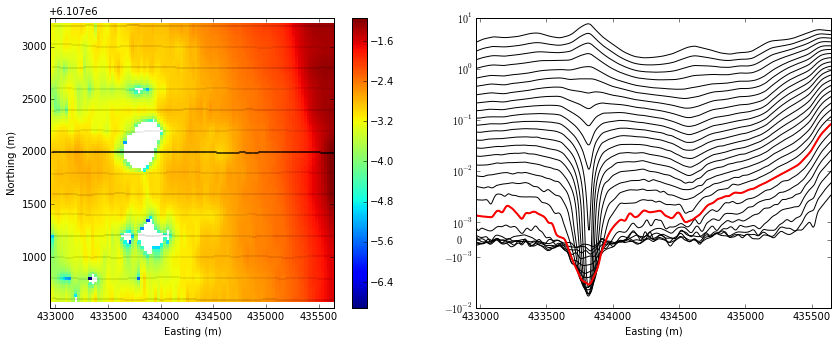

In [20]:
from ipywidgets import interact, ToggleButtons, FloatText
time_dikun = np.r_[4.6340000e-03,4.7390000e-03,4.8840000e-03,5.0820000e-03,5.3740000e-03,5.7700000e-03,6.3530000e-03,7.1450000e-03]-4.4000000e-03
time_dikun*1e6
time_vtem_mus = np.r_[99,120,141,167,198,234,281,339,406,484,573,682,818,974,1151,1370,1641,1953,2307,2745,3286,3911,4620,5495,6578,7828,9245]
txind = closestpoint(xyz[:,:2], np.r_[434000, 6.107e6+2000.])
def vizAEMdata(tind=0, iline=0,option="profile",easting=0.):
    indline = out['Line'] == lines[iline]
    timeind = 13+tind
    temp_obsint = interpolation.LinearNDInterpolator(xyz[:,:2], out['DAT'][:,timeind])
    temp_obs = temp_obsint(mesh.gridCC)
    temp_obsint = interpolation.NearestNDInterpolator(mesh.gridCC[~np.isnan(temp_obs),:], temp_obs[~np.isnan(temp_obs)])
    temp_obs = temp_obsint(mesh.gridCC)
    vmin, vmax = np.log10(temp_obs[temp_obs>0.].min()), np.log10(temp_obs[temp_obs>0.].max())
    fig = plt.figure(figsize=(14,5.2))
    ax = plt.subplot(121)
    dat = mesh.plotImage(np.log10(temp_obs), clim=(vmin, vmax),ax=ax)
    ax.plot(out['DAT'][indline,0], out['DAT'][indline,1], 'k.', ms=0.5)
    ax.plot(out['DAT'][:,0], out['DAT'][:,1], 'k.', ms=0.1, alpha = 0.5)
    # plt.scatter(xyz[:,0], xyz[:,1], s=3, c=np.log10(out['DAT'][:,timeind]), cmap='jet',edgecolor="None", clim=(vmin, vmax))
    ax.axis("equal")
    ax.set_xlim(xyz[:,0].min(), xyz[:,0].max())
    ax.set_ylim(xyz[:,1].min(), xyz[:,1].max())
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    plt.colorbar(dat[0], ax=ax)
    test, ticks, ticklabels = mapDat(out['DAT'][indline,13:], 1e-3, stretch=3)
   
    ax1 = plt.subplot(122)
    if option=="lineprofile":
        for i in range(27):
            ax1.plot(out['DAT'][indline,0], test[:,i], 'k')
        ax1.plot(out['DAT'][indline,0], test[:,tind], 'r', lw=2)            
        ax1.set_xlim(out['DAT'][indline,0].min(), out['DAT'][indline,0].max())
        ax1.set_ylim(ticks.min(), ticks.max())
        ax1.set_yticks(ticks)
        ax1.set_xlabel("Easting (m)")
        ax1.set_yticklabels(ticklabels)    
    elif option=="timedecay":
        indeast = np.argmin(abs(out['DAT'][indline,0]-easting))
        sounding, ticks_sounding, ticklabelsounding = mapDat(out['DAT'][indline,13:13+27][indeast,:], 1e-3, stretch=3)
        ax.plot(out['DAT'][indline,0][indeast], out['DAT'][indline,1][indeast], 'ro', ms=5)
        ax1.semilogx(time_vtem_mus, sounding, 'k.-', lw=2)
        ax1.semilogx(time_vtem_mus, np.zeros_like(time_vtem_mus), 'k--')
        ax1.set_yticks(ticks_sounding)
        ax1.set_yticklabels(ticklabelsounding)
        ax1.set_xlim(time_vtem_mus.min(), time_vtem_mus.max())
        ax1.grid(True)        
interact(vizAEMdata, tind=(0,26,1), 
         iline=(0,lines.size,1), 
         option=ToggleButtons(options=['lineprofile','timedecay']),
         easting=FloatText(value=434500.))    

In [55]:
ToggleButtons??

In [101]:
import matplotlib
matplotlib.rcParams['text.usetex']=True

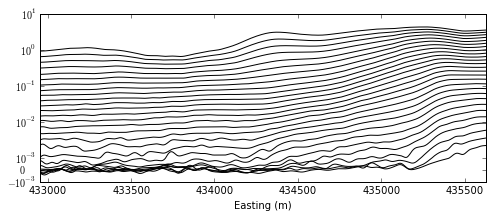

In [42]:
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
for i in range(27):
    ax.plot(out['DAT'][indline,0], test[:,i], 'k')
ax.set_xlim(out['DAT'][indline,0].min(), out['DAT'][indline,0].max())
ax.set_ylim(ticks.min(), ticks.max())
ax.set_yticks(ticks)
ax.set_xlabel("Easting (m)")
ax.set_yticklabels(ticklabels)

In [43]:
time_dikun = np.r_[4.6340000e-03,4.7390000e-03,4.8840000e-03,5.0820000e-03,5.3740000e-03,5.7700000e-03,6.3530000e-03,7.1450000e-03]-4.4000000e-03

In [44]:
time_dikun

array([ 0.000234,  0.000339,  0.000484,  0.000682,  0.000974,  0.00137 ,
        0.001953,  0.002745])

In [45]:
time_dikun*1e6
time_vtem_mus = np.r_[99,120,141,167,198,234,281,339,406,484,573,682,818,974,1151,1370,1641,1953,2307,2745,3286,3911,4620,5495,6578,7828,9245]

In [46]:
np.save('./exampledata/timevtem', time_vtem_mus*1e-6)
np.save('./exampledata/souding_cond', out['DAT'][txind,13:13+27])

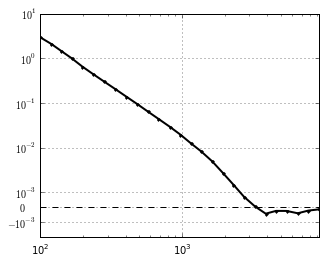

In [47]:
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)
ax.semilogx(time_vtem_mus, sounding, 'k.-', lw=2)
ax.semilogx(time_vtem_mus, np.zeros_like(time_vtem_mus), 'k--')
ax.set_yticks(ticks_sounding)
ax.set_yticklabels(ticklabelsounding)
ax.set_xlim(time_vtem_mus.min(), time_vtem_mus.max())
ax.grid(True)

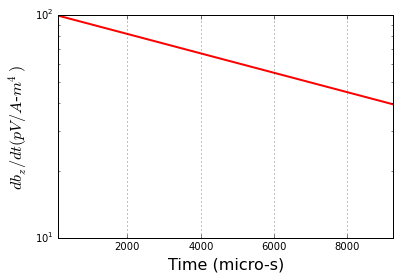

In [48]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.semilogy(time_vtem_mus, np.exp(-time_vtem_mus*1e-6/0.01)/0.01, 'r-', lw=2)
ax.set_xlim(time_vtem_mus.min(), time_vtem_mus.max())
ax.set_xlabel("Time (micro-s)", fontsize = 16)
ax.set_ylabel("$db_z/dt (pV/A$-$m^4)$ ", fontsize = 16)
ax.grid(True)

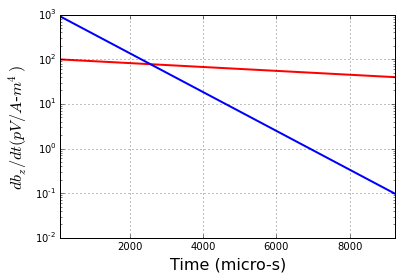

In [49]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.semilogy(time_vtem_mus, np.exp(-time_vtem_mus*1e-6/0.01)/0.01, 'r-', lw=2)
ax.semilogy(time_vtem_mus, np.exp(-time_vtem_mus*1e-6/0.001)/0.001, 'b-', lw=2)
ax.set_xlim(time_vtem_mus.min(), time_vtem_mus.max())
ax.set_xlabel("Time (micro-s)", fontsize = 16)
ax.set_ylabel("$db_z/dt (pV/A$-$m^4)$ ", fontsize = 16)
ax.grid(True)

In [50]:
# import multiprocessing as mp
# import random
# import string

# # Define an output queue
# output = mp.Queue()

# # define a example function
# def rand_string(length, output):
#     """ Generates a random string of numbers, lower- and uppercase chars. """
#     rand_str = ''.join(random.choice(
#                     string.ascii_lowercase
#                     + string.ascii_uppercase
#                     + string.digits)
#                for i in range(length))
#     output.put(rand_str)

# # Setup a list of processes that we want to run
# processes = [mp.Process(target=rand_string, args=(5, output)) for x in range(4)]

# # Run processes
# for p in processes:
#     p.start()

# # Exit the completed processes
# for p in processes:
#     p.join()

# # Get process results from the output queue
# results = [output.get() for p in processes]

# print(results)
